# Create & share pre-trained scArches on reference atlas

In this notebook, we are going to train scArches on 5 different pancreas datasets. 

Please note that, no architecture surgery is going to be performed. This is a tutorial for training scArches on a new task and share the trained network with Zenodo.

In [1]:
import os
os.chdir("/home/mohsen/projects/scnet/")

## Config GPU

if you are planning to train your scArches model on CPU, this is not necessary. 

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import scarches as sca
import scanpy as sc

Using TensorFlow backend.


In [4]:
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

In [5]:
condition_key = "study"
cell_type_key = "cell_type"

## Load reference atlas

In [6]:
adata = sca.data.read("/home/mohsen/data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [8]:
adata = adata[~adata.obs[condition_key].isin(['Pancreas CelSeq2', 'Pancreas SS2'])]

## Create scArches network from scratch 

There are some parameters that worth to be mentioned here:

1. __task_name__: name of the task which you are going to train scArches on it.
2. __x_dimension__: number of dimensions in expression space
3. __z_dimension__: number of dimensions in latent space of scArches
4. __n_conditions__: number of conditions (batches, datasets, or domains)
5. __gene_names__: list of gene names used as scArches' input
6. __model_path__: path to save trained scArches model and its configuration files.
7. __alpha__: KL divergence coefficient in the scArches' loss function
8. __beta__: MMD coefficient in the scArches' loss function. Please __NOTE__ that if beta is set to be zero, scArches' loss fucntion is equivalent to a CVAE loss function.
9. __loss_fn__: loss function to be used in scArches. Can be one of `mse`, `sse`, `nb`, or `zinb`. Please __NOTE__ that If you are going to use `nb` or `zinb` loss function, we suggest that setting `beta` hyperparameter to zero will be the best config for scArches to train on your task.

In [9]:
network = sca.models.scArches(task_name='pancreas_inDropCelSeqFC1',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 32],
                              gene_names=adata.var_names.tolist(),
                              conditions=adata.obs[condition_key].unique().tolist(),
                              lr=0.001,
                              alpha=0.0001,
                              beta=20,
                              eta=100,
                              train_device='gpu',
                              loss_fn='mse',
                              use_batchnorm=False,
                              model_path="./models/scArches/",
                              )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
scArches's network has been successfully constructed!
scNet's network has been successfully compiled!


## Train scArches

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __condition_key__: name of the column in `obs` matrix in `adata` which contains the conditions for each sample.
3. __n_epochs__: number of epochs used to train scArches.
4. __batch_size__: number of sample used to sample as mini-batches in order to optmize scArches. 
8. __save__: whether to save scArches' model and configs after training phase or not. 
9. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [10]:
network.train(adata,
              condition_key=condition_key,
              n_epochs=500,
              batch_size=512, 
              save=True, 
              retrain=True)

Instructions for updating:
Use tf.cast instead.
 |███████████---------| 57.0%  - loss: 98.9411 - mmd_loss: 1.9906 - reconstruction_loss: 96.9505 - val_loss: 98.7051 - val_mmd_loss: 2.5080 - val_reconstruction_loss: 96.19706493
scArches has been successfully saved in ./models/scArches/pancreas_inDropCelSeqFC1.


## UMAP visualization of latent space (qualitative results)

Latent space representation of reference data can be computed using `get_latent` function
This function has the following parameters:

1. __adata__: Annotated dataset to be transformed to latent space
2. __condition_key__: Name of the column in `obs` matrix in `adata` which contains the study for each sample.


In [11]:
latent_adata = network.get_latent(adata, condition_key)

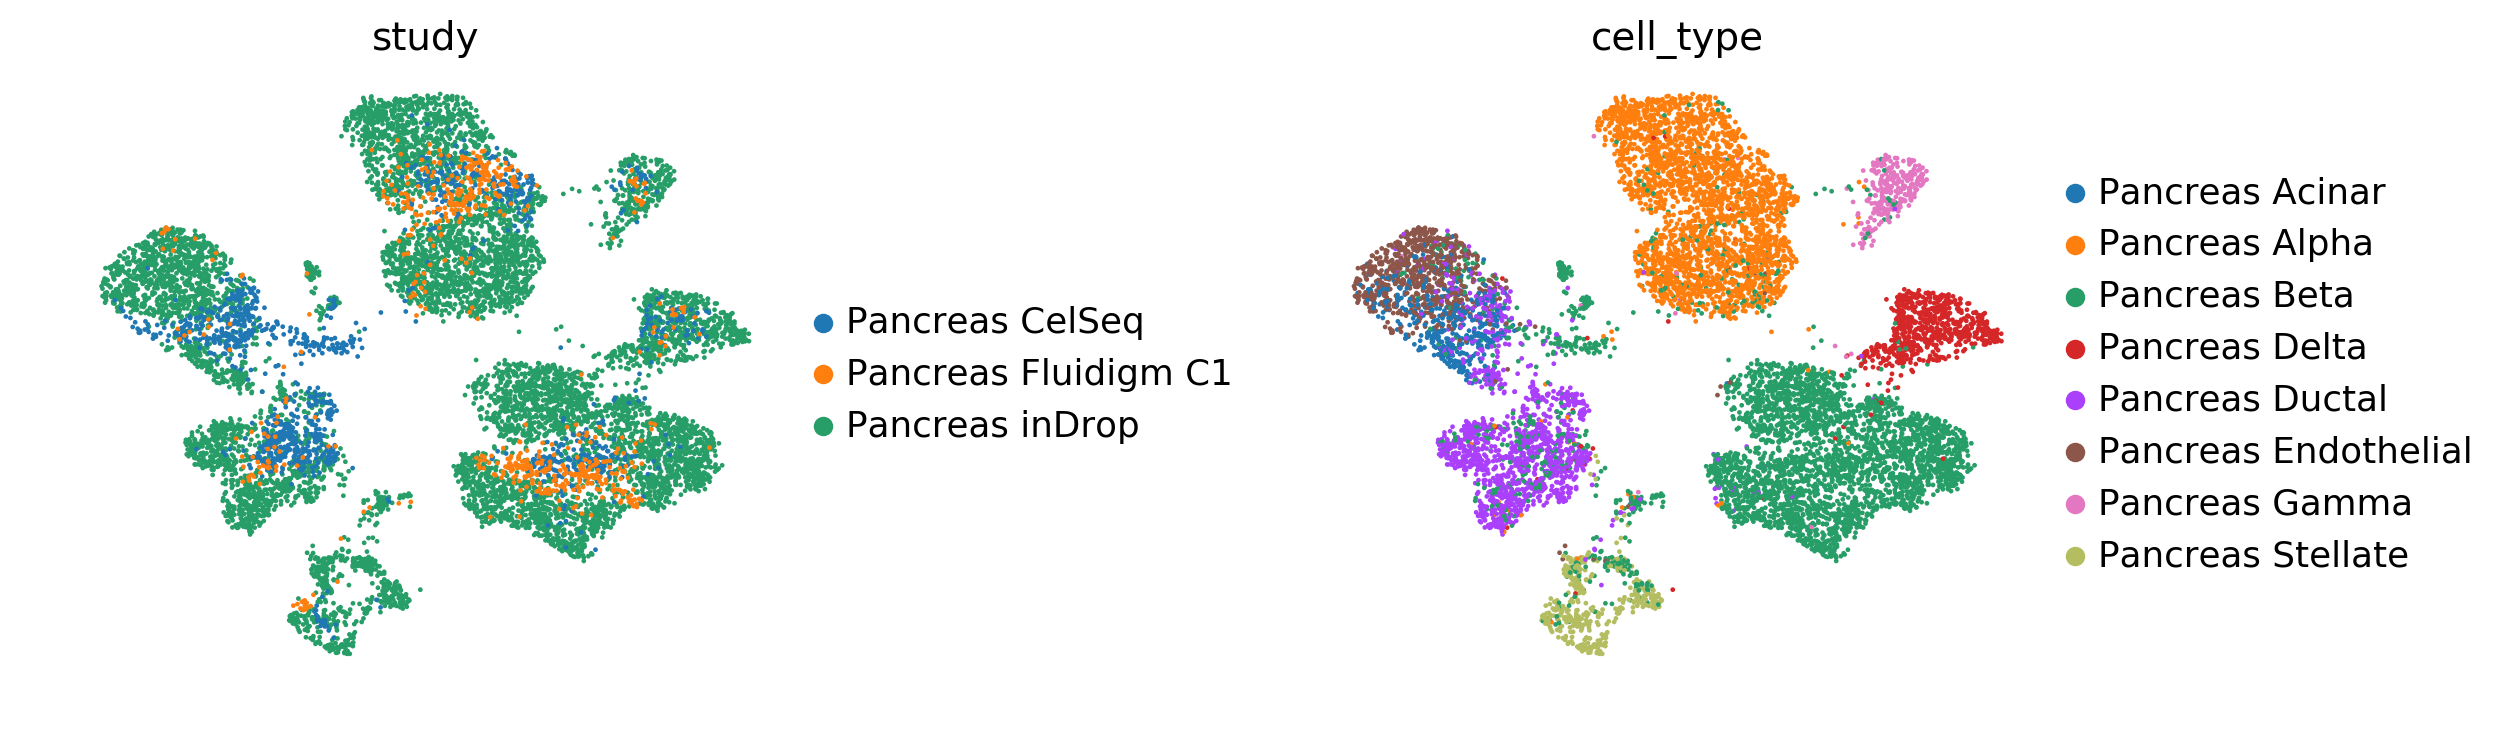

In [12]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           frameon=False, wspace=0.6)

## Share Your Trained scArches with other Researchers

You can easily get TOKEN by signing up in [**Zenodo**](https://zenodo.org/) Website and creating an app in the settings. You just have to following these steps for creating a new TOKEN: 

1. Sign in/Register in [__Zenodo__](https://zenodo.org/)
2. Go to __Applications__ page.
3. Click on __new_token__ in __Personal access tokens__ panel.
4. Give it access for `deposit:actions` and `deposit:write`.

__NOTE__: Zenodo will show the created TOKEN only once so be careful in preserving it. If you lost your TOKEN you have to create new one.

In [13]:
ACCESS_TOKEN = "GJFuigslmTKhN3CbI6Zfk7qW0uQAutxPHE8vutyDPB36McOkYbUw4aKDbBCz"

### 1. Create a Deposition in your zenodo account

You can use wrapper functions in `zenodo` module in scArches package to interact with your depositions and uploaded files in Zenodo. In Zenodo, A deposition is a cloud space for a publication, poster, etc which contains multiple files.

In order to create a deposition in Zenodo, You can call our `create_deposition` function with the following parameters:

-  __access_token__: Your access token
-  __upload_type__: Type of the deposition, has to be one of the following types defined in [here](https://developers.zenodo.org/#representation).
-  __title__: Title of the deposition.
-  __description__: Description of the deposition.
-  __creators__: List of creators of this deposition. Each item in the list has to be in the following form:

```
{
    "name": "LASTNAME, FIRSTNAME", (Has to be in this format)
    "affiliation": "AFFILIATION", (Optional)
    "orcid": "ORCID" (Optional, has to be a valid ORCID)
}
```





In [15]:
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN, 
                                             upload_type="other", 
                                             title='scArches-pancreas',
                                             description='pre-trained scArches on inDrop, CelSeq, CelSeq2, SmartSeq2, and Fluidigm C1',                                            
                                             creators=[
                                                 {"name": "Naghipourfar, Mohsen", "affiliation": "SUT"},
                                             ],
                                             )

New Deposition has been successfully created!


### 2. Upload scArches to your deposition

After creating a deposition, you can easily upload your pre-trained scArches model using `upload_model` function in `zenodo` module. This function accepts the following parameters:

- __model__: Instance of scArches' class which is trained on your task
- __deposition_id__: ID of the deposition you want to upload the model in.
- __access_token__: Your TOKEN.

The function will return the generated `download_link` in order to use and provide other 

In [16]:
download_link = sca.zenodo.upload_model(network, 
                                        deposition_id=deposition_id, 
                                        access_token=ACCESS_TOKEN)

Model has been successfully uploaded


### 3. Publish the created deposition

In [17]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

Deposition with id = 3930127 has been successfully published!


In [18]:
download_link

'https://zenodo.org/record/3930127/files/scNet-pancreas_inDropCelSeqFC1.zip?download=1'

## Congrats! Your model is ready to be downloaded by others researchers!